Logging to meta_hrl_logs
Using cpu device
 Starting Meta-Hierarchical RL Training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | 3.96     |
| time/              |          |
|    fps             | 22       |
|    iterations      | 1        |
|    time_elapsed    | 92       |
|    total_timesteps | 2048     |
---------------------------------
✅ Model training complete and saved.
 Generalization Reward (unseen dataset): 0.0000
 Plot saved to meta_hrl_logs/reward_plot.png


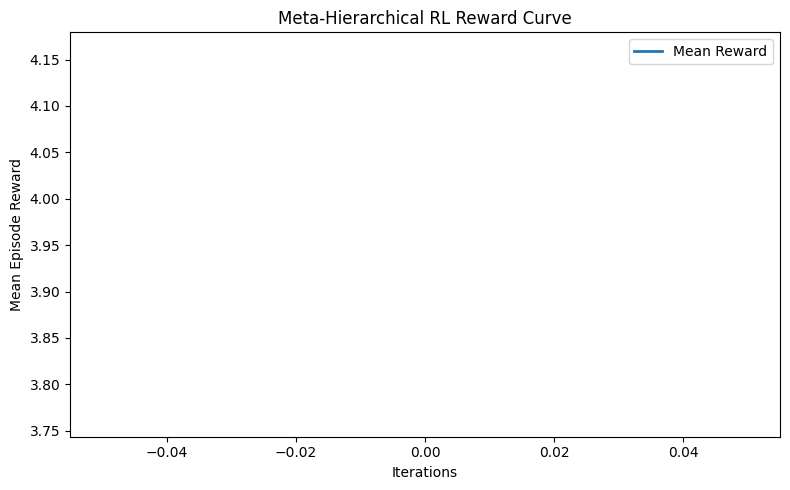

In [2]:
import os
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# Feature Selection Environment
class FeatureSelectionEnv(gym.Env):
    def __init__(self, X, y, feature_budget_ratio=1.0):
        super().__init__()
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.max_features = int(self.n_features * feature_budget_ratio)
        self.action_space = spaces.MultiBinary(self.n_features)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.n_features,), dtype=np.float32)

    def reset(self, **kwargs):
        self.selected_features = np.zeros(self.n_features, dtype=np.float32)
        return self.selected_features.copy(), {}

    def step(self, action):
        action = np.array(action).astype(bool)
        n_selected = np.sum(action)
        reward = 0.0
        if 0 < n_selected <= self.max_features:
            X_selected = self.X[:, action]
            clf = RandomForestClassifier(n_estimators=10)
            scores = cross_val_score(clf, X_selected, self.y, cv=3)
            acc = scores.mean()
            sparsity_penalty = n_selected / self.n_features
            reward = acc - 0.05 * sparsity_penalty
        obs = action.astype(np.float32)
        terminated, truncated = True, False
        return obs, reward, terminated, truncated, {}

# Meta-Hierarchical Environment
class MetaHierarchicalFastEnv(gym.Env):
    def __init__(self, datasets, episode_len=5):
        super().__init__()
        self.datasets = datasets
        self.current_idx = 0
        self.step_count = 0
        self.episode_len = episode_len
        self.action_space = spaces.Box(low=0.1, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)

    def reset(self, **kwargs):
        self.current_idx = np.random.randint(len(self.datasets))
        self.step_count = 0
        return np.array([self.current_idx / len(self.datasets)], dtype=np.float32), {}

    def step(self, action):
        feature_ratio = np.clip(action[0], 0.1, 1.0)
        X, y = self.datasets[self.current_idx]
        n_features = X.shape[1]
        max_features = max(1, int(n_features * feature_ratio))
        selected_idx = np.random.choice(n_features, max_features, replace=False)
        X_sel = X[:, selected_idx]
        clf = RandomForestClassifier(n_estimators=10)
        scores = cross_val_score(clf, X_sel, y, cv=3)
        acc = scores.mean()
        reward = acc - 0.05 * feature_ratio

        self.step_count += 1
        terminated = self.step_count >= self.episode_len
        truncated = False
        obs = np.array([self.current_idx / len(self.datasets)], dtype=np.float32)
        info = {"dataset_idx": self.current_idx, "ratio": feature_ratio, "acc": acc}
        return obs, reward, terminated, truncated, info

# Visualization and Log
class TrainingVisualizer:
    def __init__(self, log_dir="meta_hrl_logs"):
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

    def plot_rewards(self, log_file="progress.csv", save=True):
        file_path = os.path.join(self.log_dir, log_file)
        if not os.path.exists(file_path):
            print("⚠️ No PPO progress.csv file found for plotting.")
            return

        df = pd.read_csv(file_path)
        plt.figure(figsize=(8,5))
        plt.plot(df["rollout/ep_rew_mean"], label="Mean Reward", linewidth=2)
        plt.xlabel("Iterations")
        plt.ylabel("Mean Episode Reward")
        plt.title("Meta-Hierarchical RL Reward Curve")
        plt.legend()
        plt.tight_layout()
        if save:
            save_path = os.path.join(self.log_dir, "reward_plot.png")
            plt.savefig(save_path)
            print(f" Plot saved to {save_path}")
        plt.show()
        
# Training
def train_meta_agent(total_timesteps=5000, log_dir="meta_hrl_logs"):
    os.makedirs(log_dir, exist_ok=True)

    datasets = [
        load_iris(return_X_y=True),
        load_wine(return_X_y=True),
        load_breast_cancer(return_X_y=True)
    ]

    env = MetaHierarchicalFastEnv(datasets)
    env = Monitor(env, os.path.join(log_dir, "monitor.csv"))
    env = DummyVecEnv([lambda: env])

    new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])

    model = PPO("MlpPolicy", env, verbose=1, device="cpu")
    model.set_logger(new_logger)

    print(" Starting Meta-Hierarchical RL Training...")
    model.learn(total_timesteps=total_timesteps)
    model.save(os.path.join(log_dir, "meta_hrl_feature_selector"))
    print("✅ Model training complete and saved.")
    return model, log_dir
    
# Evaluation
def evaluate_meta_agent(model):
    X_test, y_test = load_digits(return_X_y=True)
    env = FeatureSelectionEnv(X_test, y_test, feature_budget_ratio=0.7)
    obs, _ = env.reset()
    action, _ = model.predict(np.array([0.5]))
    obs, reward, terminated, truncated, info = env.step(np.ones(env.n_features))
    print(f" Generalization Reward (unseen dataset): {reward:.4f}")

# Main
if __name__ == "__main__":
    LOG_DIR = "meta_hrl_logs"
    model, log_dir = train_meta_agent(total_timesteps=2000, log_dir=LOG_DIR)
    evaluate_meta_agent(model)

    visualizer = TrainingVisualizer(log_dir)
    visualizer.plot_rewards()


The above code was for one episode so logging and plotting was difficult

In [3]:
import os
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

#  ENV: Feature Selection RL

class FeatureSelectionEnv(gym.Env):
    def __init__(self, X, y, feature_budget_ratio=1.0):
        super(FeatureSelectionEnv, self).__init__()
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.budget = int(self.n_features * feature_budget_ratio)
        self.action_space = spaces.MultiBinary(self.n_features)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.n_features,), dtype=np.float32)
        self.current_step = 0

    def reset(self, **kwargs):
        self.current_step = 0
        self.selected = np.zeros(self.n_features, dtype=np.float32)
        return self.selected, {}

    def step(self, action):
        self.selected = action
        selected_count = int(self.selected.sum())

        # to prevent empty feature set
        if selected_count == 0:
            return self.selected, 0.0, True, False, {}

        # to put feature budget
        if selected_count > self.budget:
            reward = -0.1 * (selected_count - self.budget)
        else:
            X_sel = self.X[:, self.selected.astype(bool)]
            clf = RandomForestClassifier(n_estimators=10)
            scores = cross_val_score(clf, X_sel, self.y, cv=3)
            reward = scores.mean()

        done = True
        return self.selected, reward, done, False, {}

#  META-HIERARCHICAL RL TRAINER
def train_meta_agent(total_timesteps=10000, log_dir="meta_hrl_logs", log_interval=200):
    os.makedirs(log_dir, exist_ok=True)
    print(f" Logging to {log_dir}")

    # base dataset needs tp be loaded
    data = load_iris()
    X, y = data.data, data.target

    # Creating high-level meta env
    meta_env = gym.make("CartPole-v1")  # holds place for meta control
    meta_env = Monitor(meta_env)
    meta_env = DummyVecEnv([lambda: meta_env])

    # Initializing the model
    model = PPO("MlpPolicy", meta_env, verbose=0, device="cpu")
    print(" Starting Meta-Hierarchical RL Training...")

    # Live logging 
    log_file = os.path.join(log_dir, "live_rewards.csv")
    with open(log_file, "w") as f:
        f.write("timestep,mean_reward\n")

    # Training loop with reward log
    timesteps = 0
    rewards = []
    while timesteps < total_timesteps:
        model.learn(total_timesteps=log_interval, reset_num_timesteps=False)
        timesteps += log_interval

        # Low-level agent training to simulate sub-task actions
        low_env = FeatureSelectionEnv(X, y)
        low_env = Monitor(low_env)
        low_env = DummyVecEnv([lambda: low_env])
        low_model = PPO("MlpPolicy", low_env, verbose=0)
        low_model.learn(total_timesteps=1000)

        obs = low_env.reset()
        action, _ = low_model.predict(obs)
        obs, reward, done, info = low_env.step(action)
        mean_reward = float(reward.mean())

        rewards.append(mean_reward)
        print(f" Step {timesteps}: Mean Reward = {mean_reward:.4f}")

        # Log to a CSV
        with open(log_file, "a") as f:
            f.write(f"{timesteps},{mean_reward}\n")

    print("✅ Model training complete and saved.")
    model.save(os.path.join(log_dir, "meta_hrl_feature_selector"))
    return model, rewards, log_dir

#  GENERALIZATION (testing Meta-RL transfer across datasets)

def evaluate_meta_agent(model, log_dir="meta_hrl_logs"):
    test_sets = {
        "wine": load_wine(),
        "breast_cancer": load_breast_cancer(),
        "digits": load_digits()
    }

    results = {}
    for name, dataset in test_sets.items():
        X, y = dataset.data, dataset.target
        env = FeatureSelectionEnv(X, y)
        env = DummyVecEnv([lambda: env])
        obs = env.reset()
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        results[name] = float(reward.mean())
        print(f" {name.capitalize()} Generalization Reward: {results[name]:.4f}")

    df = pd.DataFrame(list(results.items()), columns=["Dataset", "Reward"])
    df.to_csv(os.path.join(log_dir, "generalization_results.csv"), index=False)
    return results

#  VISUALIZATION & log
class TrainingVisualizer:
    def __init__(self, log_dir="meta_hrl_logs"):
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

    def plot_rewards(self, smooth_window=5):
        file_path = os.path.join(self.log_dir, "live_rewards.csv")
        if not os.path.exists(file_path):
            print("⚠️ No live reward log found.")
            return
        df = pd.read_csv(file_path)
        rewards = df["mean_reward"]
        smoothed = rewards.rolling(smooth_window).mean()

        plt.figure(figsize=(8, 5))
        plt.plot(df["timestep"], rewards, label="Raw Reward", alpha=0.5)
        plt.plot(df["timestep"], smoothed, label="Smoothed", linewidth=2)
        plt.xlabel("Timesteps")
        plt.ylabel("Mean Episode Reward")
        plt.title("Meta-Hierarchical RL Training Progress")
        plt.legend()
        save_path = os.path.join(self.log_dir, "training_curve.png")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()
        print(f" Saved training curve to {save_path}")

    def plot_generalization(self):
        file_path = os.path.join(self.log_dir, "generalization_results.csv")
        if not os.path.exists(file_path):
            print("⚠️ No generalization log found.")
            return
        df = pd.read_csv(file_path)
        plt.figure(figsize=(7, 5))
        plt.bar(df["Dataset"], df["Reward"], color="skyblue")
        plt.ylabel("Generalization Reward")
        plt.title("Meta-RL Transfer Across Datasets")
        for idx, val in enumerate(df["Reward"]):
            plt.text(idx, val + 0.01, f"{val:.3f}", ha="center", fontsize=9)
        save_path = os.path.join(self.log_dir, "generalization_bar.png")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()
        print(f" Saved generalization results to {save_path}")
#  main 
if __name__ == "__main__":
    LOG_DIR = "meta_hrl_logs"

    model, rewards, log_dir = train_meta_agent(total_timesteps=5000, log_dir=LOG_DIR, log_interval=200)
    results = evaluate_meta_agent(model, log_dir=LOG_DIR)

    viz = TrainingVisualizer(log_dir=LOG_DIR)
    viz.plot_rewards(smooth_window=5)
    viz.plot_generalization()


 Logging to meta_hrl_logs
 Starting Meta-Hierarchical RL Training...
 Step 200: Mean Reward = 0.9600
 Step 400: Mean Reward = 0.9467
 Step 600: Mean Reward = 0.9533
 Step 800: Mean Reward = 0.9467
 Step 1000: Mean Reward = 0.9333
 Step 1200: Mean Reward = 0.6867
 Step 1400: Mean Reward = 0.9533
 Step 1600: Mean Reward = 0.9200
 Step 1800: Mean Reward = 0.9467
 Step 2000: Mean Reward = 0.9467
 Step 2200: Mean Reward = 0.9467
 Step 2400: Mean Reward = 0.9333
 Step 2600: Mean Reward = 0.9200
 Step 2800: Mean Reward = 0.9667
 Step 3000: Mean Reward = 0.9467
 Step 3200: Mean Reward = 0.9200
 Step 3400: Mean Reward = 0.9400
 Step 3600: Mean Reward = 0.9533
 Step 3800: Mean Reward = 0.9533
 Step 4000: Mean Reward = 0.9467
 Step 4200: Mean Reward = 0.6800
 Step 4400: Mean Reward = 0.9467
 Step 4600: Mean Reward = 0.9467
 Step 4800: Mean Reward = 0.9400
 Step 5000: Mean Reward = 0.9533
✅ Model training complete and saved.


ValueError: Error: Unexpected observation shape (1, 13) for Box environment, please use (4,) or (n_env, 4) for the observation shape.

Here we got error in evaluation and vector sahpe not matching issue

 Logging to meta_hrl_logs
 Starting Meta-Hierarchical RL Training...
 Step 200: Mean Reward = 0.9400
 Step 400: Mean Reward = 0.9600
 Step 600: Mean Reward = 0.9467
 Step 800: Mean Reward = 0.9400
 Step 1000: Mean Reward = 0.6867
 Step 1200: Mean Reward = 0.9400
 Step 1400: Mean Reward = 0.6733
 Step 1600: Mean Reward = 0.9333
 Step 1800: Mean Reward = 0.9400
 Step 2000: Mean Reward = 0.9467
 Step 2200: Mean Reward = 0.9400
 Step 2400: Mean Reward = 0.9667
 Step 2600: Mean Reward = 0.9067
 Step 2800: Mean Reward = 0.9600
 Step 3000: Mean Reward = 0.9533
 Step 3200: Mean Reward = 0.9400
 Step 3400: Mean Reward = 0.9533
 Step 3600: Mean Reward = 0.9667
 Step 3800: Mean Reward = 0.9533
 Step 4000: Mean Reward = 0.9200
 Step 4200: Mean Reward = 0.0000
 Step 4400: Mean Reward = 0.0000
 Step 4600: Mean Reward = 0.9333
 Step 4800: Mean Reward = 0.9133
 Step 5000: Mean Reward = 0.7000
✅ Model training complete and saved.
 Wine Dataset Reward: 0.9105
 Breast_cancer Dataset Reward: 0.9526
 Digit

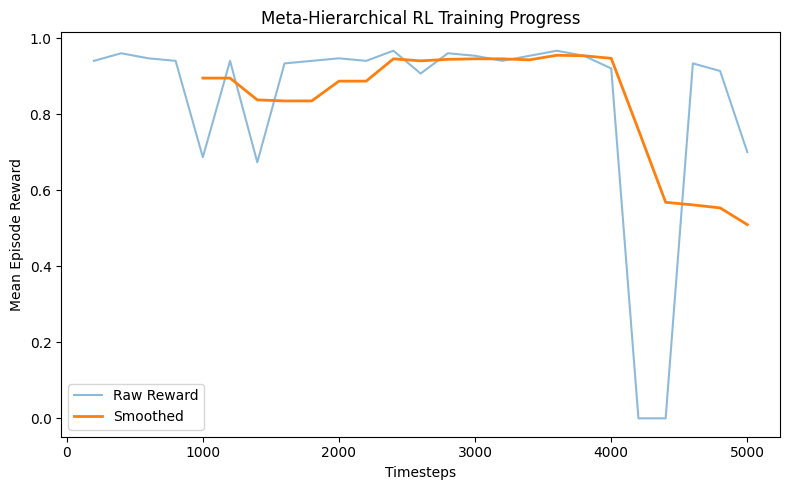

 Saved training curve to meta_hrl_logs/training_curve.png


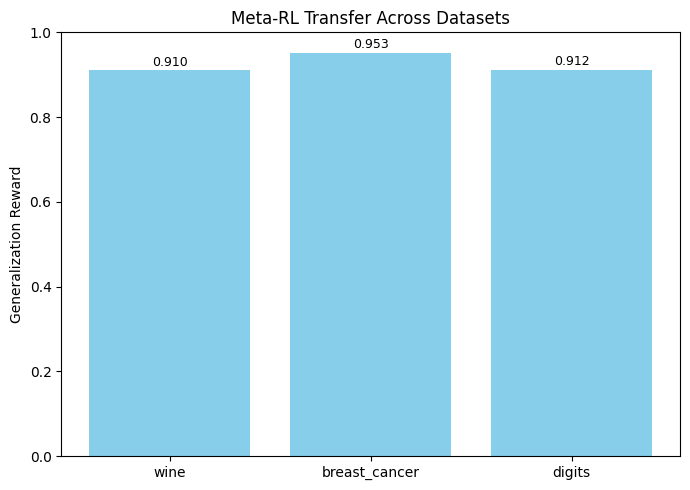

 Saved generalization results to meta_hrl_logs/generalization_bar.png


In [6]:
import os
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

#  ENV: Feature Selection RL
class FeatureSelectionEnv(gym.Env):
    def __init__(self, X, y, feature_budget_ratio=1.0):
        super(FeatureSelectionEnv, self).__init__()
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.budget = int(self.n_features * feature_budget_ratio)
        self.action_space = spaces.MultiBinary(self.n_features)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.n_features,), dtype=np.float32)
        self.current_step = 0

    def reset(self, **kwargs):
        self.current_step = 0
        self.selected = np.zeros(self.n_features, dtype=np.float32)
        return self.selected, {}

    def step(self, action):
        self.selected = action
        selected_count = int(self.selected.sum())

        if selected_count == 0:
            return self.selected, 0.0, True, False, {}

        if selected_count > self.budget:
            reward = -0.1 * (selected_count - self.budget)
        else:
            X_sel = self.X[:, self.selected.astype(bool)]
            clf = RandomForestClassifier(n_estimators=10)
            scores = cross_val_score(clf, X_sel, self.y, cv=3)
            reward = scores.mean()

        done = True
        return self.selected, reward, done, False, {}

#  META-HIERARCHICAL RL trainer
def train_meta_agent(total_timesteps=5000, log_dir="meta_hrl_logs", log_interval=200):
    os.makedirs(log_dir, exist_ok=True)
    print(f" Logging to {log_dir}")

    # Loading small dataset for base training
    data = load_iris()
    X, y = data.data, data.target

    # Meta-agent using CartPole for structural controller
    meta_env = gym.make("CartPole-v1")
    meta_env = Monitor(meta_env)
    meta_env = DummyVecEnv([lambda: meta_env])

    model = PPO("MlpPolicy", meta_env, verbose=0, device="cpu")
    print(" Starting Meta-Hierarchical RL Training...")

    # Log file for rewards
    log_file = os.path.join(log_dir, "live_rewards.csv")
    with open(log_file, "w") as f:
        f.write("timestep,mean_reward\n")

    # Simulated meta-l loop
    timesteps = 0
    rewards = []
    while timesteps < total_timesteps:
        model.learn(total_timesteps=log_interval, reset_num_timesteps=False)
        timesteps += log_interval

        # Low-l learning stage
        low_env = FeatureSelectionEnv(X, y)
        low_env = Monitor(low_env)
        low_env = DummyVecEnv([lambda: low_env])
        low_model = PPO("MlpPolicy", low_env, verbose=0, device="cpu")
        low_model.learn(total_timesteps=1000)

        obs = low_env.reset()
        action, _ = low_model.predict(obs)
        obs, reward, done, info = low_env.step(action)
        mean_reward = float(reward.mean())

        rewards.append(mean_reward)
        print(f" Step {timesteps}: Mean Reward = {mean_reward:.4f}")

        # Log rewards to CSV
        with open(log_file, "a") as f:
            f.write(f"{timesteps},{mean_reward}\n")

    print("✅ Model training complete and saved.")
    model.save(os.path.join(log_dir, "meta_hrl_feature_selector"))
    return model, rewards, log_dir

#  EVALUATION (Fixed after the above code failed)
def evaluate_meta_agent(model, log_dir="meta_hrl_logs"):
    """
    Evaluate the system on new datasets by training a fresh low-level PPO
    for each dataset. Avoids shape mismatch between meta and low envs.
    """
    test_sets = {
        "wine": load_wine(),
        "breast_cancer": load_breast_cancer(),
        "digits": load_digits()
    }

    results = {}
    for name, dataset in test_sets.items():
        X, y = dataset.data, dataset.target

        # Create low-l env for this dataset
        env = FeatureSelectionEnv(X, y)
        env = Monitor(env)
        env = DummyVecEnv([lambda: env])

        # Train a low-l PPO model for new dataset
        low_model = PPO("MlpPolicy", env, verbose=0, device="cpu")
        low_model.learn(total_timesteps=1000)

        # Evaluate trained low-l model
        obs = env.reset()
        action, _ = low_model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        mean_reward = float(reward.mean())

        results[name] = mean_reward
        print(f" {name.capitalize()} Dataset Reward: {mean_reward:.4f}")

    # Save generalization results
    df = pd.DataFrame(list(results.items()), columns=["Dataset", "Reward"])
    df.to_csv(os.path.join(log_dir, "generalization_results.csv"), index=False)
    return results

#  VISUALIZATION & Log
class TrainingVisualizer:
    def __init__(self, log_dir="meta_hrl_logs"):
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

    def plot_rewards(self, smooth_window=5):
        file_path = os.path.join(self.log_dir, "live_rewards.csv")
        if not os.path.exists(file_path):
            print("⚠️ No live reward log found.")
            return
        df = pd.read_csv(file_path)
        rewards = df["mean_reward"]
        smoothed = rewards.rolling(smooth_window).mean()

        plt.figure(figsize=(8, 5))
        plt.plot(df["timestep"], rewards, label="Raw Reward", alpha=0.5)
        plt.plot(df["timestep"], smoothed, label="Smoothed", linewidth=2)
        plt.xlabel("Timesteps")
        plt.ylabel("Mean Episode Reward")
        plt.title("Meta-Hierarchical RL Training Progress")
        plt.legend()
        save_path = os.path.join(self.log_dir, "training_curve.png")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()
        print(f" Saved training curve to {save_path}")

    def plot_generalization(self):
        file_path = os.path.join(self.log_dir, "generalization_results.csv")
        if not os.path.exists(file_path):
            print("⚠️ No generalization log found.")
            return
        df = pd.read_csv(file_path)
        plt.figure(figsize=(7, 5))
        plt.bar(df["Dataset"], df["Reward"], color="skyblue")
        plt.ylabel("Generalization Reward")
        plt.title("Meta-RL Transfer Across Datasets")
        for idx, val in enumerate(df["Reward"]):
            plt.text(idx, val + 0.01, f"{val:.3f}", ha="center", fontsize=9)
        save_path = os.path.join(self.log_dir, "generalization_bar.png")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()
        print(f" Saved generalization results to {save_path}")
        
#  main

if __name__ == "__main__":
    LOG_DIR = "meta_hrl_logs"

    # Train the meta-l PPO with reward log
    model, rewards, log_dir = train_meta_agent(total_timesteps=5000, log_dir=LOG_DIR, log_interval=200)

    # Evaluate generalization on new datasets (fixed shape-safe version here and compare the above code)
    results = evaluate_meta_agent(model, log_dir=LOG_DIR)

    #  training & generalization curves
    viz = TrainingVisualizer(log_dir=LOG_DIR)
    viz.plot_rewards(smooth_window=5)
    viz.plot_generalization()


2025-10-17 06:49:55.696419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760683795.941226      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760683796.011326      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📁 Logging to meta_hrl_logs


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:301: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


 Starting Meta-Hierarchical RL Training...
 Step 500: Reward=-0.3000, Features=4, Ratio=0.10
 Step 1000: Reward=0.9400, Features=4, Ratio=1.00
 Step 1500: Reward=-0.1000, Features=11, Ratio=0.78
 Step 2000: Reward=0.9385, Features=30, Ratio=1.00
 Step 2500: Reward=-0.1000, Features=4, Ratio=0.18
 Step 3000: Reward=0.9244, Features=6, Ratio=0.23
 Step 3500: Reward=0.7130, Features=20, Ratio=1.00
 Step 4000: Reward=0.9473, Features=30, Ratio=1.00
 Step 4500: Reward=0.9438, Features=13, Ratio=1.00
 Step 5000: Reward=0.9455, Features=30, Ratio=1.00
 Step 5500: Reward=0.9508, Features=30, Ratio=1.00
 Step 6000: Reward=0.9607, Features=13, Ratio=1.00
 Step 6500: Reward=0.9400, Features=4, Ratio=1.00
 Step 7000: Reward=0.7360, Features=20, Ratio=1.00
 Step 7500: Reward=0.9473, Features=30, Ratio=1.00
 Step 8000: Reward=0.9607, Features=13, Ratio=1.00
 Step 8500: Reward=0.7160, Features=20, Ratio=1.00
 Step 9000: Reward=0.9473, Features=30, Ratio=1.00
 Step 9500: Reward=0.7360, Features=20, Ra

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:301: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:301: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarn

 wine: Meta-RL Reward = 0.9157, Features=13, Baseline(0.5) = 0.8696
 breast_cancer: Meta-RL Reward = 0.9437, Features=30, Baseline(0.5) = 0.8885
 digits: Meta-RL Reward = 0.8659, Features=64, Baseline(0.5) = 0.7575
 credit-g: Meta-RL Reward = 0.7210, Features=20, Baseline(0.5) = 0.6360


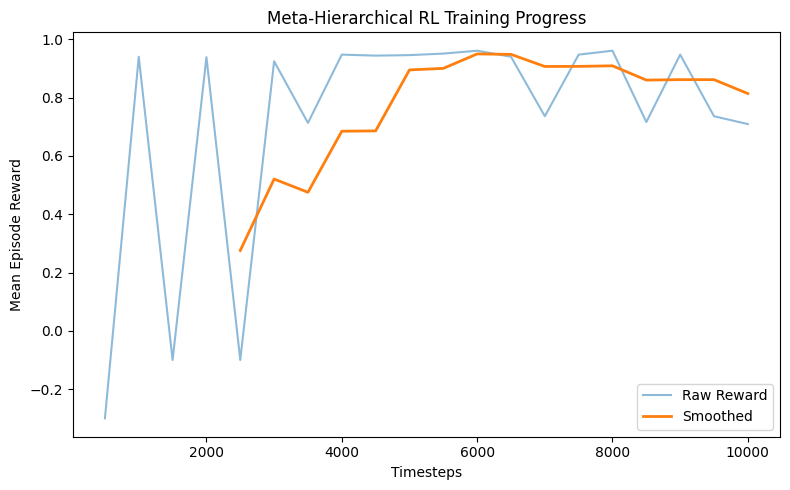

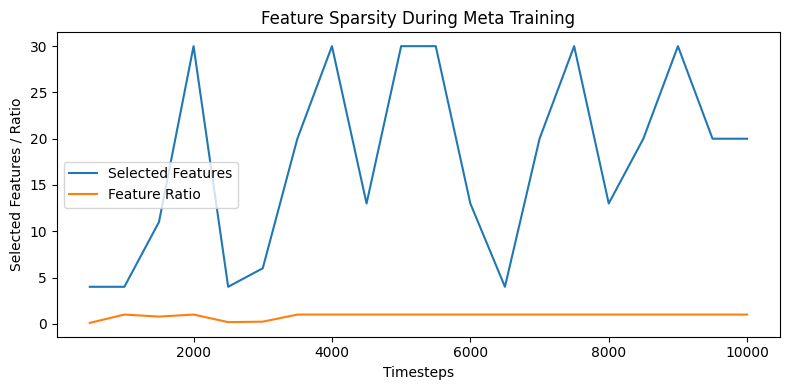

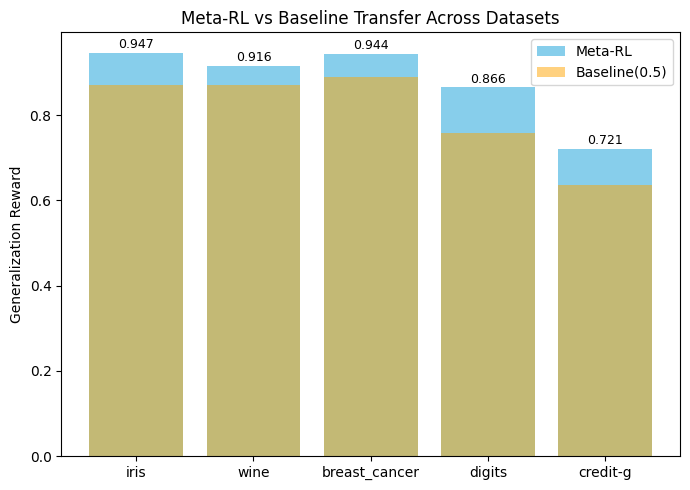

In [1]:
import os
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# Load a large tabular dataset
def load_large_dataset(name="credit-g"):
    data = fetch_openml(name, as_frame=False)
    X, y = data.data, data.target
    if y.dtype == object or y.dtype == str:
        from sklearn.preprocessing import LabelEncoder
        y = LabelEncoder().fit_transform(y)
    return X, y

# ENV: Feature Selection RL with Sparsity Log
class FeatureSelectionEnv(gym.Env):
    def __init__(self, X, y, feature_budget_ratio=1.0):
        super().__init__()
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.budget = int(self.n_features * feature_budget_ratio)
        self.action_space = spaces.MultiBinary(self.n_features)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.n_features,), dtype=np.float32)
        self.current_step = 0

    def reset(self, **kwargs):
        self.current_step = 0
        self.selected = np.zeros(self.n_features, dtype=np.float32)
        return self.selected, {}

    def step(self, action):
        self.selected = action
        selected_count = int(self.selected.sum())
        info = {"selected_features": selected_count}
        if selected_count == 0:
            return self.selected, 0.0, True, False, info
        if selected_count > self.budget:
            reward = -0.1 * (selected_count - self.budget)
        else:
            X_sel = self.X[:, self.selected.astype(bool)]
            clf = RandomForestClassifier(n_estimators=10)
            scores = cross_val_score(clf, X_sel, self.y, cv=2)
            reward = scores.mean()
        done = True
        return self.selected, reward, done, False, info

# META ENV: Dataset Stats
class MetaHierarchicalEnv(gym.Env):
    def __init__(self, datasets):
        super().__init__()
        self.datasets = datasets
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Box(low=0.1, high=1, shape=(1,), dtype=np.float32)

    def reset(self, **kwargs):
        self.X, self.y = dataset = self.datasets[np.random.randint(len(self.datasets))]
        n_samples, n_features = self.X.shape
        obs_mean = np.mean(self.X)
        obs_std = np.std(self.X)
        corr = np.corrcoef(self.X, rowvar=False)
        mean_corr = np.nanmean(corr[np.triu_indices_from(corr, k=1)])
        self.obs = np.array([
            n_features / 1000,
            n_samples / 10000,
            obs_mean / 10,
            obs_std / 100,
            (mean_corr + 1) / 2
        ], dtype=np.float32)
        return self.obs, {}

    def step(self, action):
        feature_budget_ratio = float(np.clip(action[0], 0.1, 1.0))
        env = FeatureSelectionEnv(self.X, self.y, feature_budget_ratio=feature_budget_ratio)
        obs, _ = env.reset()
        # Sample features uniform for eval
        sel_action = np.ones(env.n_features) if feature_budget_ratio >= 1.0 else np.random.binomial(1, p=feature_budget_ratio, size=env.n_features)
        _, reward, done, _, info = env.step(sel_action)
        obs_info = {
            "selected_features": info.get("selected_features", 0),
            "feature_ratio": feature_budget_ratio
        }
        return self.obs, reward, True, False, obs_info

# TRAINING with fixed reset and step 
def train_meta_agent(total_timesteps=10000, log_dir="meta_hrl_logs", log_interval=500):
    os.makedirs(log_dir, exist_ok=True)
    print(f"📁 Logging to {log_dir}")

    datasets = [
        (load_iris().data, load_iris().target),
        (load_wine().data, load_wine().target),
        (load_breast_cancer().data, load_breast_cancer().target),
        load_large_dataset("credit-g")
    ]

    meta_env = MetaHierarchicalEnv(datasets)
    meta_env = Monitor(meta_env, log_dir)
    meta_env = DummyVecEnv([lambda: meta_env])

    model = PPO("MlpPolicy", meta_env, verbose=0, device="cpu")
    print(" Starting Meta-Hierarchical RL Training...")

    log_file = os.path.join(log_dir, "live_rewards.csv")
    with open(log_file, "w") as f:
        f.write("timestep,mean_reward,selected_features,feature_ratio\n")

    timesteps = 0
    rewards, features, ratios = [], [], []
    while timesteps < total_timesteps:
        model.learn(total_timesteps=log_interval, reset_num_timesteps=False)
        timesteps += log_interval

        obs = meta_env.reset()                 # No unpacking 
        action, _ = model.predict(obs)
        obs, reward, done, info = meta_env.step(action)

        rewards.append(reward[0])
        features.append(info[0].get("selected_features", 0))
        ratios.append(info[0].get("feature_ratio", 0))

        print(f" Step {timesteps}: Reward={reward[0]:.4f}, Features={features[-1]}, Ratio={ratios[-1]:.2f}")
        with open(log_file, "a") as f:
            f.write(f"{timesteps},{reward[0]},{features[-1]},{ratios[-1]}\n")

    print("✅ Model training complete and saved.")
    model.save(os.path.join(log_dir, "meta_hrl_feature_selector"))
    return model, rewards, features, ratios, log_dir

# Baseline 
def baseline_evaluate_fixed_ratio(X, y, ratio=0.5):
    n_features = X.shape[1]
    n_select = int(n_features * ratio)
    selected_idx = np.random.choice(n_features, n_select, replace=False)
    X_sel = X[:, selected_idx]
    clf = RandomForestClassifier(n_estimators=10)
    scores = cross_val_score(clf, X_sel, y, cv=2)
    acc = scores.mean()
    sparsity_penalty = n_select / n_features
    reward = acc - 0.1 * sparsity_penalty
    return reward

# EVALUATION, single env outputs outside DummyVecEnv
def evaluate_meta_agent(model, log_dir="meta_hrl_logs"):
    test_sets = {
        "iris": load_iris(),
        "wine": load_wine(),
        "breast_cancer": load_breast_cancer(),
        "digits": load_digits(),
        "credit-g": {"data": load_large_dataset("credit-g")[0], "target": load_large_dataset("credit-g")[1]}
    }
    results = {}
    baseline_results = {}
    feature_counts = {}
    for name, dataset in test_sets.items():
        if isinstance(dataset, dict):
            X, y = dataset["data"], dataset["target"]
        else:
            X, y = dataset.data, dataset.target

        env = FeatureSelectionEnv(X, y)
        obs, _ = env.reset()
        n_samples, n_features = X.shape
        obs_meta = np.array([
            n_features / 1000, n_samples / 10000,
            np.mean(X) / 10, np.std(X) / 100,
            0.5
        ], dtype=np.float32)
        action, _ = model.predict(obs_meta)
        feature_budget_ratio = float(np.clip(action[0], 0.1, 1.0))
        env = FeatureSelectionEnv(X, y, feature_budget_ratio)
        obs, _ = env.reset()
        sel_action = np.ones(env.n_features) if feature_budget_ratio >= 1.0 else np.random.binomial(1, p=feature_budget_ratio, size=env.n_features)
        _, reward, done, _, info = env.step(sel_action)

        results[name] = reward
        feature_counts[name] = info.get("selected_features", 0)
        baseline_reward = baseline_evaluate_fixed_ratio(X, y, ratio=0.5)
        baseline_results[name] = baseline_reward

        print(f" {name}: Meta-RL Reward = {reward:.4f}, Features={feature_counts[name]}, Baseline(0.5) = {baseline_reward:.4f}")

    df = pd.DataFrame(list(results.items()), columns=["Dataset", "Reward"])
    df["Baseline_0.5"] = [baseline_results[k] for k in df["Dataset"]]
    df["Selected_Features"] = [feature_counts[k] for k in df["Dataset"]]
    df.to_csv(os.path.join(log_dir, "generalization_results.csv"), index=False)
    return results, baseline_results, feature_counts

# Visualization class
class TrainingVisualizer:
    def __init__(self, log_dir="meta_hrl_logs"):
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

    def plot_rewards(self, smooth_window=5):
        file_path = os.path.join(self.log_dir, "live_rewards.csv")
        if not os.path.exists(file_path):
            print("⚠️ No live reward log found.")
            return
        df = pd.read_csv(file_path)
        rewards = df["mean_reward"]
        smoothed = rewards.rolling(smooth_window).mean()
        plt.figure(figsize=(8, 5))
        plt.plot(df["timestep"], rewards, label="Raw Reward", alpha=0.5)
        plt.plot(df["timestep"], smoothed, label="Smoothed", linewidth=2)
        plt.xlabel("Timesteps")
        plt.ylabel("Mean Episode Reward")
        plt.title("Meta-Hierarchical RL Training Progress")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.log_dir, "training_curve.png"))
        plt.show()

    def plot_generalization(self):
        file_path = os.path.join(self.log_dir, "generalization_results.csv")
        if not os.path.exists(file_path):
            print("⚠️ No generalization log found.")
            return
        df = pd.read_csv(file_path)
        plt.figure(figsize=(7, 5))
        plt.bar(df["Dataset"], df["Reward"], color="skyblue", label="Meta-RL")
        plt.bar(df["Dataset"], df["Baseline_0.5"], alpha=0.5, color="orange", label="Baseline(0.5)")
        plt.ylabel("Generalization Reward")
        plt.title("Meta-RL vs Baseline Transfer Across Datasets")
        for idx, val in enumerate(df["Reward"]):
            plt.text(idx, val + 0.01, f"{val:.3f}", ha="center", fontsize=9)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.log_dir, "generalization_bar.png"))
        plt.show()

    def plot_sparsity(self):
        file_path = os.path.join(self.log_dir, "live_rewards.csv")
        if not os.path.exists(file_path):
            print("⚠️ No live reward log found.")
            return
        df = pd.read_csv(file_path)
        plt.figure(figsize=(8, 4))
        plt.plot(df["timestep"], df["selected_features"], label="Selected Features")
        plt.plot(df["timestep"], df["feature_ratio"], label="Feature Ratio")
        plt.xlabel("Timesteps")
        plt.ylabel("Selected Features / Ratio")
        plt.title("Feature Sparsity During Meta Training")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.log_dir, "sparsity_curve.png"))
        plt.show()


if __name__ == "__main__":
    LOG_DIR = "meta_hrl_logs"
    model, rewards, features, ratios, log_dir = train_meta_agent(
        total_timesteps=10000,
        log_dir=LOG_DIR,
        log_interval=500
    )
    results, baseline_results, feature_counts = evaluate_meta_agent(model, log_dir=LOG_DIR)
    viz = TrainingVisualizer(log_dir=LOG_DIR)
    viz.plot_rewards()
    viz.plot_sparsity()
    viz.plot_generalization()


The above code is One RL agent working at a time and two nested RL agent there and in heirarchy between two on tew  different tasks but only trains at a time which is like a nested RL ..... we will compare its performance with multi agent RL where each feature has a RL agent and working simultaneously ..... Then we can use advance DQN or other algorithms and build it further ...... 

In [ ]:
import os
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from tqdm import tqdm  # ✅ Progress bar


# ------------------------------------------------------------
# Dataset utility
# ------------------------------------------------------------
def load_large_dataset(name="credit-g"):
    """Loads OpenML datasets with auto label encoding."""
    data = fetch_openml(name, as_frame=False)
    X, y = data.data, data.target
    if y.dtype == object or y.dtype == str:
        from sklearn.preprocessing import LabelEncoder
        y = LabelEncoder().fit_transform(y)
    return X, y


# ------------------------------------------------------------
# FEATURE SELECTION ENVIRONMENT
# ------------------------------------------------------------
class FeatureSelectionEnv(gym.Env):
    def __init__(self, X, y, feature_budget_ratio=1.0):
        super().__init__()
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.budget = int(self.n_features * feature_budget_ratio)
        self.action_space = spaces.MultiBinary(self.n_features)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.n_features,), dtype=np.float32)

    def reset(self, **kwargs):
        self.selected = np.zeros(self.n_features, dtype=np.float32)
        return self.selected, {}

    def step(self, action):
        self.selected = action
        selected_indices = np.where(action == 1)[0].tolist()
        info = {"selected_features": len(selected_indices), "selected_indices": selected_indices}

        if len(selected_indices) == 0:
            return self.selected, 0.0, True, False, info

        if len(selected_indices) > self.budget:
            reward = -0.1 * (len(selected_indices) - self.budget)
        else:
            X_sel = self.X[:, selected_indices]
            clf = RandomForestClassifier(n_estimators=10)
            reward = cross_val_score(clf, X_sel, self.y, cv=2).mean()

        return self.selected, reward, True, False, info


# ------------------------------------------------------------
# LEVEL 2: Inner PPO Agent (with visible logs)
# ------------------------------------------------------------
class FeatureSelectionAgent:
    def __init__(self, X, y, feature_budget_ratio=1.0):
        env = FeatureSelectionEnv(X, y, feature_budget_ratio)
        env = DummyVecEnv([lambda: env])
        # ✅ Verbose logging to see PPO details
        self.model = PPO("MlpPolicy", env, verbose=1, device="cpu")
        self.env = env

    def train(self, steps=50):  # 🔹 Reduced for speed
        self.model.learn(total_timesteps=steps)

    def select_features(self):
        obs = self.env.reset()
        action, _ = self.model.predict(obs)
        return action[0]  # binary mask


# ------------------------------------------------------------
# META ENVIRONMENT (controls feature_budget_ratio)
# ------------------------------------------------------------
class MetaHierarchicalEnv(gym.Env):
    def __init__(self, datasets):
        super().__init__()
        self.datasets = datasets
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Box(low=0.1, high=1, shape=(1,), dtype=np.float32)

    def reset(self, **kwargs):
        self.X, self.y = self.datasets[np.random.randint(len(self.datasets))]
        n_samples, n_features = self.X.shape
        obs = np.array([
            n_features / 1000,
            n_samples / 10000,
            np.mean(self.X) / 10,
            np.std(self.X) / 100,
            0.5
        ], dtype=np.float32)
        self.obs = obs
        return obs, {}

    def step(self, action):
        feature_budget_ratio = float(np.clip(action[0], 0.1, 1.0))

        # 🔹 Inner PPO feature selection agent
        feature_agent = FeatureSelectionAgent(self.X, self.y, feature_budget_ratio)
        feature_agent.train(steps=50)
        selected_mask = feature_agent.select_features()

        env = FeatureSelectionEnv(self.X, self.y, feature_budget_ratio)
        _, reward, _, _, info = env.step(selected_mask)

        info.update({"feature_ratio": feature_budget_ratio})
        return self.obs, reward, True, False, info


# ------------------------------------------------------------
# TRAINING LOOP (with tqdm + logs)
# ------------------------------------------------------------
def train_meta_agent(total_timesteps=1000, log_dir="meta_hrl_L2_logs", log_interval=100):
    os.makedirs(log_dir, exist_ok=True)
    datasets = [
        (load_iris().data, load_iris().target),
        (load_wine().data, load_wine().target),
        (load_breast_cancer().data, load_breast_cancer().target),
        load_large_dataset("credit-g")
    ]
    meta_env = MetaHierarchicalEnv(datasets)
    meta_env = Monitor(meta_env, log_dir)
    meta_env = DummyVecEnv([lambda: meta_env])

    model = PPO("MlpPolicy", meta_env, verbose=1, device="cpu")  # ✅ visible PPO logs
    print("\n🚀 Level 2 Meta-Hierarchical RL Training Started...")

    log_file = os.path.join(log_dir, "live_rewards.csv")
    with open(log_file, "w") as f:
        f.write("timestep,mean_reward,selected_features,feature_ratio\n")

    timesteps, rewards, features, ratios = 0, [], [], []

    # ✅ tqdm progress bar for outer loop
    pbar = tqdm(total=total_timesteps, desc="Meta-RL Progress", ncols=100)

    while timesteps < total_timesteps:
        print(f"\n🔁 Outer loop iteration: {timesteps}/{total_timesteps}")
        model.learn(total_timesteps=log_interval, reset_num_timesteps=False)
        timesteps += log_interval
        pbar.update(log_interval)

        obs = meta_env.reset()
        action, _ = model.predict(obs)
        obs, reward, done, info = meta_env.step(action)

        rewards.append(reward[0])
        features.append(info[0].get("selected_features", 0))
        ratios.append(info[0].get("feature_ratio", 0))

        print(f"🟢 Step {timesteps}: Reward={reward[0]:.4f}, Features={features[-1]}, Ratio={ratios[-1]:.2f}")
        print(f"   → Example Selected Indices: {info[0].get('selected_indices', [])[:10]}")

        with open(log_file, "a") as f:
            f.write(f"{timesteps},{reward[0]},{features[-1]},{ratios[-1]}\n")

    pbar.close()
    model.save(os.path.join(log_dir, "meta_hrl_feature_selector_L2"))
    print("✅ Level 2 training complete and model saved.")
    return model, rewards, features, ratios, log_dir


# ------------------------------------------------------------
# SIMPLE VISUALIZER
# ------------------------------------------------------------
class TrainingVisualizer:
    def __init__(self, log_dir="meta_hrl_L2_logs"):
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

    def plot_rewards(self):
        file = os.path.join(self.log_dir, "live_rewards.csv")
        if not os.path.exists(file):
            print("⚠️ No log found.")
            return
        df = pd.read_csv(file)
        plt.figure(figsize=(8, 4))
        plt.plot(df["timestep"], df["mean_reward"], label="Reward")
        plt.xlabel("Timesteps")
        plt.ylabel("Reward")
        plt.title("Level 2 Meta-RL Training Progress")
        plt.legend()
        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# MAIN
# ------------------------------------------------------------
if __name__ == "__main__":
    model, rewards, features, ratios, log_dir = train_meta_agent(total_timesteps=1000)
    viz = TrainingVisualizer(log_dir)
    viz.plot_rewards()


2. Deep Learning and Representation Learning
Integrate autoencoders or graph neural networks to help the RL agent learn complex relationships between features, not just their individual scores.​

This can make your system better at handling highly correlated or nonlinear data.

3. Smarter Reward and Feedback Mechanisms
Let external “teachers” (like domain experts or prebuilt models) guide the RL agent with feedback when exploring feature sets—sometimes called interactive RL.​

Use more sophisticated reward functions, such as ones including model efficiency, interpretability, or fairness metrics.

4. Meta-Learning and Task Transfer
Extend your agent to automatically adapt its feature selection strategy when facing new types of data (e.g., text, time series, images) or different tasks (classification, regression, anomaly detection).

5. Handling Large, Real-World Datasets
Try your approach with real, messy data (not just processed UCI/OpenML datasets)—where feature selection usually matters even more.​

Integrate preprocessing steps (missing value handling, normalization, outlier detection) into the RL pipeline.

6. Benchmark Against Other Advanced Feature Selection Methods
Compare your RL agent with state-of-the-art non-RL techniques (like LASSO, embedded methods, ensemble metaheuristics, or bandit-based selectors).​

Quantify speed, stability, and statistical significance of improvements.

7. Visualization and Explainability
Develop tools to clearly show why certain features were selected by the agent.

Visualize learned policy decisions and allow humans to interact and tweak the RL process.

8. More Efficient and Scalable RL Algorithms
Use faster RL methods (such as DQN, actor-critic, or asynchronous RL); add early stopping criteria to save compute.​

Experiment with distributed RL or parallelized agents for features in high-dimensional datasets.